In [1]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.contrib.eager as tfe

RANDOM_SEED = 42

tf.enable_eager_execution()
tf.set_random_seed(RANDOM_SEED)

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

Instructions for updating:
Use the retry module or similar alternatives.
TensorFlow version: 1.7.0
Eager execution: True


In [2]:
dataset_fp = "../DataSource/output2_2kg.csv"

def parse_csv(line):
    # Set field types
    example_defaults = [[0], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.]]
    parsed_line = tf.decode_csv(line, example_defaults, field_delim=";")
    # Last 10 fields are features, combine into single tensor
    features_ = tf.reshape(parsed_line[5:15], shape=[10])
    # Label is an index of beam's part where defect occurs
    label_ = tf.reshape(parsed_line[1], shape=[]) // 20
    label_ = tf.cast(label_, tf.int32)
    return features_, label_

dataset = tf.data.TextLineDataset(dataset_fp)
dataset = dataset.skip(1)

train_dataset_size = 8000
train_dataset = dataset.take(train_dataset_size)
train_dataset = train_dataset.map(parse_csv)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(64)

test_dataset = dataset.skip(train_dataset_size)
test_dataset = test_dataset.map(parse_csv)
test_dataset = test_dataset.shuffle(buffer_size=10000)
test_dataset = test_dataset.batch(64)

# View a single example entry from a batch
features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor(
[0.17869666 0.34252048 0.48471713 0.60756284 0.711507   0.7965439
 0.8626951  0.90993685 0.93827623 0.94826776], shape=(10,), dtype=float32)
example label: tf.Tensor(1, shape=(), dtype=int32)


In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation="relu", input_shape=(10,)),  # input shape required
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10)
])

def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)

# keep results for plotting
train_loss_results = []
train_accuracy_results = []
test_loss_results = []
test_accuracy_results = []

In [4]:
num_epochs = 10001

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    # Training loop - using batches of 64
    for x, y in tfe.Iterator(train_dataset):
        # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    # Evaluate the model on the test dataset
    test_loss_avg = tfe.metrics.Mean()
    test_accuracy = tfe.metrics.Accuracy()

    for x, y in tfe.Iterator(test_dataset):
        prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
        test_loss_avg(loss(model, x, y))
        test_accuracy(prediction, y)

    test_loss_results.append(test_loss_avg.result())
    test_accuracy_results.append(test_accuracy.result())
    
    if epoch % 100 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
        
        print("Test set: Loss: {:.3f}, Accuracy: {:.3%}".format(test_loss_avg.result(),
                                                                test_accuracy.result()))

Epoch 000: Loss: 2.269, Accuracy: 12.800%
Test set: Loss: 2.274, Accuracy: 11.100%
Epoch 100: Loss: 1.532, Accuracy: 45.212%
Test set: Loss: 1.617, Accuracy: 43.100%
Epoch 200: Loss: 1.399, Accuracy: 48.375%
Test set: Loss: 1.500, Accuracy: 45.050%
Epoch 300: Loss: 1.329, Accuracy: 50.062%
Test set: Loss: 1.430, Accuracy: 46.950%
Epoch 400: Loss: 1.283, Accuracy: 51.550%
Test set: Loss: 1.369, Accuracy: 49.500%
Epoch 500: Loss: 1.251, Accuracy: 52.575%
Test set: Loss: 1.330, Accuracy: 51.050%
Epoch 600: Loss: 1.226, Accuracy: 53.212%
Test set: Loss: 1.301, Accuracy: 51.200%
Epoch 700: Loss: 1.207, Accuracy: 53.838%
Test set: Loss: 1.275, Accuracy: 51.750%
Epoch 800: Loss: 1.191, Accuracy: 54.288%
Test set: Loss: 1.261, Accuracy: 52.200%
Epoch 900: Loss: 1.175, Accuracy: 55.025%
Test set: Loss: 1.240, Accuracy: 53.350%
Epoch 1000: Loss: 1.160, Accuracy: 55.425%
Test set: Loss: 1.227, Accuracy: 54.200%
Epoch 1100: Loss: 1.148, Accuracy: 55.650%
Test set: Loss: 1.215, Accuracy: 54.400%
Ep

Epoch 9800: Loss: 0.903, Accuracy: 62.500%
Test set: Loss: 0.956, Accuracy: 60.950%
Epoch 9900: Loss: 0.902, Accuracy: 62.525%
Test set: Loss: 0.956, Accuracy: 61.200%
Epoch 10000: Loss: 0.901, Accuracy: 62.513%
Test set: Loss: 0.955, Accuracy: 61.150%


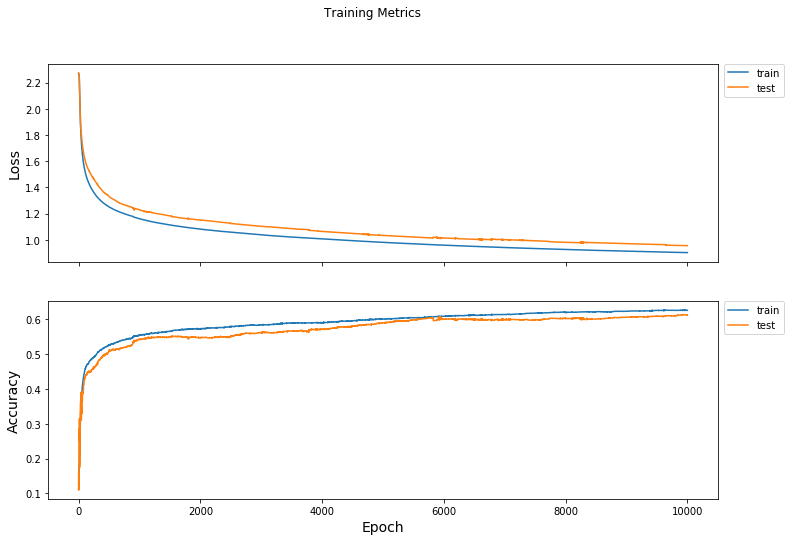

In [5]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results, label="train")
axes[0].plot(test_loss_results, label="test")
axes[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results, label="train")
axes[1].plot(test_accuracy_results, label="test")
axes[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [6]:
def predict(input_tensor):
    print("input tensor:", input_tensor)
    prediction = model(input_tensor)
    print("prediction:", prediction)
    probabilities = tf.contrib.util.constant_value(tf.nn.softmax(prediction))[0]
    plt.bar(range(10), probabilities, tick_label=range(10))
    plt.show()

input tensor: tf.Tensor(
[[0.1786674  0.3392767  0.48101023 0.60972714 0.72463435 0.8186188
  0.8847279  0.93197733 0.96031654 0.9703081 ]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-31.145967  -13.139379   -4.6159477   5.2532463  10.677966    9.071516
    4.759985   -5.7452726 -24.723244  -16.00094  ]], shape=(1, 10), dtype=float32)


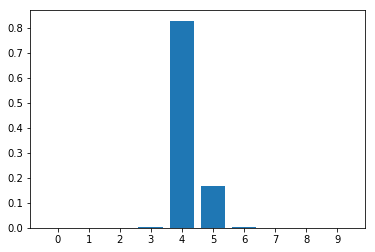

In [11]:
# Defect at (90.0, 14.0) with extent 10
predict(tf.convert_to_tensor([[
    0.1786673937420182,
    0.3392766868462858,
    0.48101021506271097,
    0.6097271549464971,
    0.7246343291551015,
    0.8186187667071658,
    0.8847279021514868,
    0.9319773563593714,
    0.9603165536211958,
    0.9703080969821836
]]))

input tensor: tf.Tensor(
[[0.17866175 0.3392871  0.48101184 0.6056347  0.7219559  0.81009907
  0.8762217  0.9234719  0.95181113 0.96180266]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-24.730349  -11.673618   -5.3470364   2.4476652   6.918749    5.9280744
    2.8435786  -4.463433  -17.96164   -12.096549 ]], shape=(1, 10), dtype=float32)


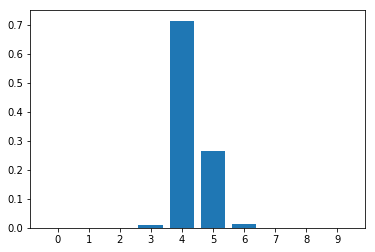

In [12]:
# Defect at (90.0, 14.0) with extent 6
predict(tf.convert_to_tensor([[
    0.1786617484778206,
    0.3392870977075673,
    0.4810118477682601,
    0.6056346667918132,
    0.7219558726012127,
    0.8100990500862282,
    0.876221724048476,
    0.9234719401124436,
    0.9518111204513261,
    0.9618026639739699
]]))

input tensor: tf.Tensor(
[[0.17866738 0.33927748 0.48102653 0.61564344 0.72725624 0.826922
  0.893062   0.9403071  0.96865195 0.97864354]], shape=(1, 10), dtype=float32)
prediction: tf.Tensor(
[[-37.36942   -13.811539   -3.2551663   8.255874   13.866417   11.296584
    5.998575   -7.3724737 -31.974716  -20.37837  ]], shape=(1, 10), dtype=float32)


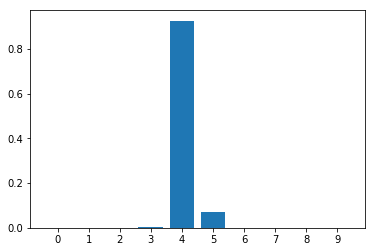

In [13]:
# Defect at (90.0, 14.0) with extent 14
predict(tf.convert_to_tensor([[
    0.17866738050075093,
    0.33927747029662964,
    0.48102654369382813,
    0.6156434188191063,
    0.7272562279732668,
    0.8269220225176204,
    0.8930619788663562,
    0.9403071089482046,
    0.968651950600269,
    0.9786435178209939
]]))